Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


2-way split | LogisticRegression | Acc: 0.868 | F1: 0.8689755355376464
2-way split | RandomForest       | Acc: 1.0 | F1: 1.0

3-way split (val) | LogisticRegression | Acc: 0.805 | F1: 0.8086942297468612
3-way split (val) | RandomForest       | Acc: 1.0 | F1: 1.0

3-way split (test) | LogisticRegression | Acc: 0.86 | F1: 0.86116976705212
3-way split (test) | RandomForest       | Acc: 1.0 | F1: 1.0


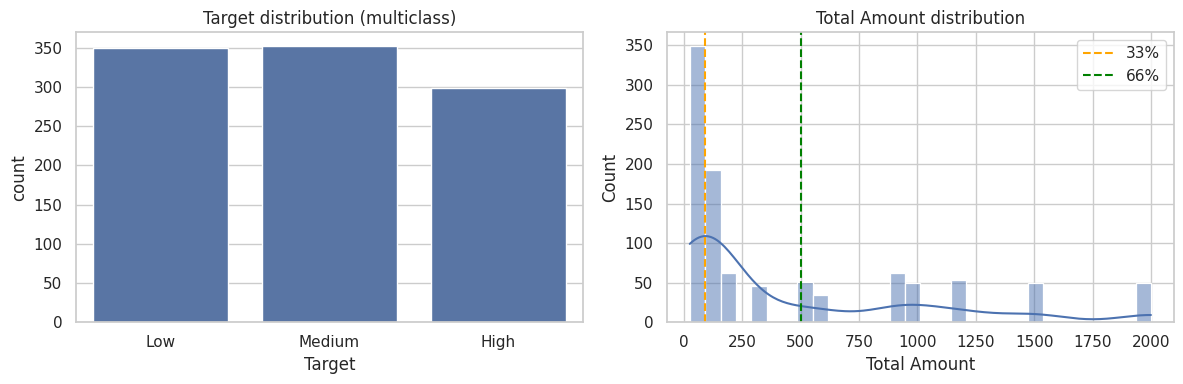

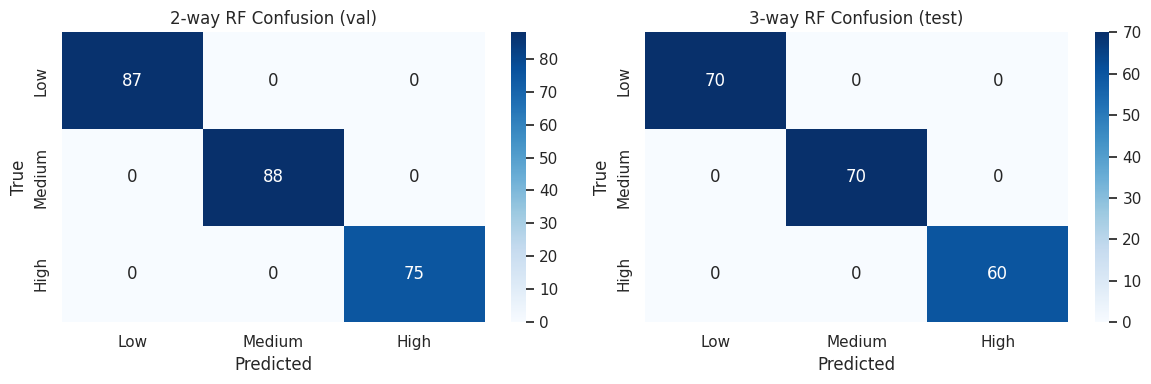

/tmp/ipython-input-361070445.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='viridis')


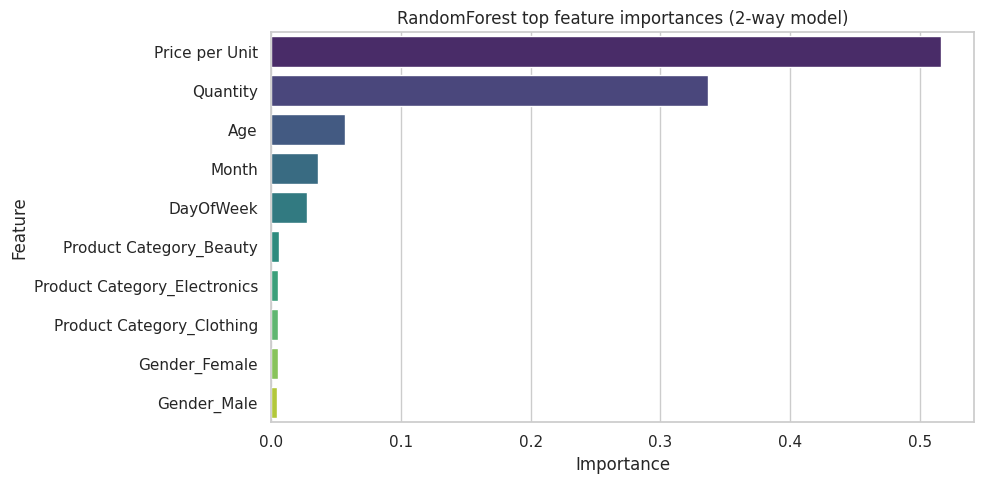

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

sns.set(style='whitegrid', context='notebook')

csv_path = "/content/drive/MyDrive/retail_sales_dataset.csv"
df = pd.read_csv(csv_path)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

mode = 'multiclass'  # 'binary' or 'multiclass'

if mode == 'binary':
    thr = df['Total Amount'].quantile(0.66)
    df['Target'] = (df['Total Amount'] > thr).astype(int)
else:
    q_low, q_high = df['Total Amount'].quantile([0.33, 0.66])
    df['Target'] = pd.cut(df['Total Amount'],
                          bins=[-np.inf, q_low, q_high, np.inf],
                          labels=['Low','Medium','High'],
                          include_lowest=True)

feature_num = ['Age', 'Quantity', 'Price per Unit', 'Month', 'DayOfWeek']
feature_cat = ['Gender', 'Product Category']
X = df[feature_num + feature_cat].copy()
y = df['Target'].copy()

X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train3, X_val3, y_train3, y_val3 = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

preprocess = ColumnTransformer([
    ('num', StandardScaler(), feature_num),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), feature_cat)
])

avg = 'binary' if mode=='binary' else 'macro'

log_pipe2 = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=2000, multi_class='auto'))])
rf_pipe2  = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample'))])

log_pipe3 = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=2000, multi_class='auto'))])
rf_pipe3  = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample'))])

log_pipe2.fit(X_train2, y_train2)
rf_pipe2.fit(X_train2, y_train2)

log_pipe3.fit(X_train3, y_train3)
rf_pipe3.fit(X_train3, y_train3)

pred2_log = log_pipe2.predict(X_val2)
pred2_rf  = rf_pipe2.predict(X_val2)

pred3_val_log = log_pipe3.predict(X_val3)
pred3_val_rf  = rf_pipe3.predict(X_val3)
pred3_test_log = log_pipe3.predict(X_test)
pred3_test_rf  = rf_pipe3.predict(X_test)

print('2-way split | LogisticRegression | Acc:', accuracy_score(y_val2, pred2_log), '| F1:', f1_score(y_val2, pred2_log, average=avg))
print('2-way split | RandomForest       | Acc:', accuracy_score(y_val2, pred2_rf),  '| F1:', f1_score(y_val2, pred2_rf,  average=avg))
print('\n3-way split (val) | LogisticRegression | Acc:', accuracy_score(y_val3, pred3_val_log), '| F1:', f1_score(y_val3, pred3_val_log, average=avg))
print('3-way split (val) | RandomForest       | Acc:', accuracy_score(y_val3, pred3_val_rf),  '| F1:', f1_score(y_val3, pred3_val_rf,  average=avg))
print('\n3-way split (test) | LogisticRegression | Acc:', accuracy_score(y_test, pred3_test_log), '| F1:', f1_score(y_test, pred3_test_log, average=avg))
print('3-way split (test) | RandomForest       | Acc:', accuracy_score(y_test, pred3_test_rf),  '| F1:', f1_score(y_test, pred3_test_rf,  average=avg))

fig, axes = plt.subplots(1, 2, figsize=(12,4))
if mode == 'binary':
    sns.countplot(x=y, ax=axes[0])
    axes[0].set_title('Target distribution (binary)')
else:
    sns.countplot(x=y, order=['Low','Medium','High'], ax=axes[0])
    axes[0].set_title('Target distribution (multiclass)')
sns.histplot(df['Total Amount'], bins=30, kde=True, ax=axes[1])
axes[1].axvline(df['Total Amount'].quantile(0.33), color='orange', linestyle='--', label='33%')
axes[1].axvline(df['Total Amount'].quantile(0.66), color='green', linestyle='--', label='66%')
axes[1].set_title('Total Amount distribution')
axes[1].legend()
plt.tight_layout()
plt.show()

def plot_conf(ax, y_true, y_pred, title, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels if labels is not None else None,
                yticklabels=labels if labels is not None else None)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

if mode == 'binary':
    labels_bin = [0,1]
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_conf(axes[0], y_val2, pred2_rf, '2-way RF Confusion (val)', labels_bin)
    plot_conf(axes[1], y_test, pred3_test_rf, '3-way RF Confusion (test)', labels_bin)
    plt.tight_layout(); plt.show()
else:
    labels_mc = ['Low','Medium','High']
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    plot_conf(axes[0], y_val2, pred2_rf, '2-way RF Confusion (val)', labels_mc)
    plot_conf(axes[1], y_test, pred3_test_rf, '3-way RF Confusion (test)', labels_mc)
    plt.tight_layout(); plt.show()

rf_model2 = rf_pipe2.named_steps['clf']
ohe = rf_pipe2.named_steps['prep'].named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(feature_cat))
all_feature_names = feature_num + cat_feature_names
importances = pd.Series(rf_model2.feature_importances_, index=all_feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=importances.values[:15], y=importances.index[:15], palette='viridis')
plt.title('RandomForest top feature importances (2-way model)')
plt.xlabel('Importance'); plt.ylabel('Feature')
plt.tight_layout(); plt.show()
